# Figure Notebook

In [1]:
"""
Import needed libraries
"""

import numpy as np
import pandas as pd
from copy import copy
import sys
import my_shell_tools

# analysis
from scipy.stats import ttest_ind_from_stats
import itertools

# geomip_data
import os.path
# import cf
from netCDF4 import Dataset

# plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import LogNorm

In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
"""
Import all from projects python scripts
"""

from gfdl_data import *
from get_glens_data import *
from analysis import *
from plotting import *

In [4]:
"""
How much of this needed?
"""

# Directory and filenames for annual timeseries of 2D data
glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
glens_template = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'

vars_glens = ['TREFHT','TREFHTMX','P-E','PRECTMX']
exps_glens = ['control','feedback']
years = ['2010-2029','2075-2094']

# year ranges which appears in filename
control_file_years = '201001-209912'
control_short_file_years = '201001-203012'
feedback_file_years = '202001-209912'

seas = 'ann'
stats = ['mean','std']

"""
Specify years of experiments and associated indices for annual files
"""

years_control = np.array([IDX + 2010 for IDX in range(90)])
years_feedback = np.array([IDX + 2020 for IDX in range(80)])

#Generate the indices for the range of years in each case.
# [0] added as a 2 element tuple with an array and an empty slot returned rather than an array
t_index_control = np.where((years_control > 2074) & (years_control < 2095))[0]
t_index_baseline = np.where((years_control > 2009) & (years_control < 2030))[0]
t_index_feedback = np.where((years_feedback > 2074) & (years_feedback < 2095))[0]

"""
How much of this needed?
"""

'\nHow much of this needed?\n'

In [10]:
"""
Generate means and stds for all variables and cases
"""

# get lons, lats and weights
lons, lats, weights = get_lons_lats_weights()

# returnes (Means, Stds) for all cases and vars
all_data = get_all_cases_vars() # {(var,case)}
"""
CASES:
'Baseline'     - RCP8.5 @ 2010-2029
'RCP8.5'       - RCP8.5 @ 2075-2094
'Full-GLENS'   - GLENS  @ 2075-2094
'Half-GLENS'   - Scaled Half-GLENS  @ 2075-2094
'Baseline-2'   - RCP8.5 @ 2010-2029 W/ alternate runs
'Full-GLENS-2'   - GLENS @ 2075-2094 W/ alternate runs
'Half-GLENS-2'   - Scaled Half-GLENS @ 2075-2094 W/ alternate runs on GLENS (not on RCP8.5)
### NOT DONE ### 'Half-GLENS-time' - Shifted Half-GLENS @ 2075-2094 AND ?????
"""

# get weights and masks
all_masks = get_glens_masks_weights() # all_masks[masks]
"""
MASKS:
'land_mask' - binary land mask where land fraction > 50%
'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
WEIGHTS:
'pop' - gridcell weighting by population fraction
'ag' - gridcell weighting by agricultural land fraction
'area' - simple gridcell weighting by area
'land_area' - land area weighting using raw land area fraction (not mask)
'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
"""


"\nMASKS:\n'land_mask' - binary land mask where land fraction > 50%\n'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%\nWEIGHTS:\n'pop' - gridcell weighting by population fraction\n'ag' - gridcell weighting by agricultural land fraction\n'area' - simple gridcell weighting by area\n'land_area' - land area weighting using raw land area fraction (not mask)\n'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)\n"

In [6]:
"""
Set standard plot options
"""

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'figure.figsize': cm2inch(8.5,8.5)})

# color guide here: https://www.w3schools.com/colors/colors_picker.asp
# color blender here: https://meyerweb.com/eric/tools/color-blend
red = '#ff0000'
l_red = '#ffc0c0' # old: '#ffd9d9'
blue = '#0066ff'
l_blue = '#c0c0ff' # old:'#b2d0ff'
purple = '#803380'
l_purple = '#C099C0' 

std_alpha = 0.2

In [7]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300 # set inline images to hi-res
%matplotlib inline

# INSERT FIGURE SECTIONS HERE

In [16]:
var = 'P-E'
mask = all_masks['land_noice_area']
value = ['Full-GLENS','RCP8.5','Baseline']
sg_anom, co2_anom, sg_CO2_anom, masks, weights, fractions = better_worse_full_data(all_data, value[0], value[1], value[2], var, mask, anom_type='standard')
sg_anom_pc, co2_anom_pc, sg_CO2_anom_pc, masks, weights, fractions = better_worse_full_data(all_data, value[0], value[1], value[2], var, mask, anom_type='pc')
sg_anom_SD, co2_anom_SD, sg_CO2_anom_SD, masks, weights, fractions = better_worse_full_data(all_data, value[0], value[1], value[2], var, mask, anom_type='SD')

In [11]:
# %load figure_sections/fig_2.py

"""
GFDL 2D histogram
"""

from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import gridspec
import matplotlib.patches as patches

"""
Define function to get data in format for plot
"""

def sort_axes(axis, xlims, ylims, xnum_steps, ynum_steps, num_format='%0.1f'):
    
    axis.set_xlim(xlims)
    axis.set_ylim(ylims)

    axis.set_yticks(np.linspace(ylims[0],ylims[1],xnum_steps))
    axis.set_xticks(np.linspace(ylims[0],ylims[1],ynum_steps))

    axis.xaxis.set_major_formatter(ticker.FormatStrFormatter(num_format))
    axis.yaxis.set_major_formatter(ticker.FormatStrFormatter(num_format))

def add_lines(axis):
    axis.axhline(0, color='k',zorder=0, lw=0.6)
    axis.axvline(0, color='k',zorder=0, lw=0.6)
    axis.plot(xlims,xlims, color='k',zorder=0, lw=0.6)
    axis.plot([xlims[0],-1.*xlims[0]],[-1.*xlims[0],xlims[0]], color='k',zorder=0, lw=0.6)
    
def bw_off_plot_func(CO2_anom,values,mask,weight):
    
    # Calculate fraction of CO2 anom distribution across values with weighted mask
    bwd = np.array(fraction_distribution(CO2_anom[mask], values, sample_weight=weight[mask]))
    # Return 100* fraction of points at each interval that are masked
    return 100 * bwd / (total * np.sum(weight) / np.sum(weight[mask]))
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    #https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
    
"""
settings
"""

out_dir = '/n/home03/pjirvine/projects/fraction_better_off/figures/fig_2/'

frac_100 = False
background = True
line_1_99_top = True
line_1_99_bottom = True
angled_labels = True

"""
Get mask
"""

weight = gfdl_masks['land_noice_area'].flatten()

"""
Common settings
"""

bounds = [1.e-6,1.e-5,1.e-4,1.e-3,1.e-2,1.e-1]
labels = ['$10^{-6}$','$10^{-5}$','$10^{-4}$','$10^{-3}$','$10^{-2}$','$10^{-1}$']

cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# g_cmap = plt.cm.gist_gray
# g_norm = mpl.colors.BoundaryNorm(bounds, g_cmap.N)

nbins = 200

"""
Create figure
"""

fig = plt.figure(figsize=cm2inch(15,13))
plt.rcParams.update({'font.size': 8})

"""
Start TOP
"""

"""
p-e no filter
"""

axis = fig.add_subplot(221)
ax_pe_top = axis

var = 'pe'

plt.title('Precipitation - Evaporation (PE)')

plt.axis('scaled')

CO2_anom, SRM_anom, masks, weights = hist2d_gfdl_data(gfdl_data, var, weight, frac_100=frac_100)

# Set axes and add lines

xlims = [-1.5,1.5]
ylims = xlims
xnum_steps, ynum_steps = 7, 7

sort_axes(axis, xlims, ylims, xnum_steps, ynum_steps, num_format='%0.1f')

add_lines(axis)

# produce plot

img = axis.hist2d(CO2_anom, SRM_anom, bins=nbins, range = [xlims,ylims], weights=weight, norm=norm, cmap=cmap, cmin=bounds[0], cmax=bounds[-1])
# img = ax_pe.hist2d(CO2_anom[certain], SRM_anom[certain], bins=100, range = [xlims,ylims], weights=weight[certain], norm=norm, cmap=cmap, cmin=1.e-12)

if line_1_99_top:
    range_1_99 = weighted_quantile(CO2_anom, [0.01,0.99], sample_weight=weight)
    
    plt.plot([range_1_99[0],range_1_99[0]],[1.5,-2.5],color='0.5', lw=0.6, clip_on=False)
    plt.plot([range_1_99[1],range_1_99[1]],[1.5,-2.5],color='0.5', lw=0.6, clip_on=False)
    
    plt.plot([range_1_99[0],range_1_99[1]],[-1.8,-1.8],color='0.5', lw=0.6, clip_on=False)
    plt.text( (range_1_99[0]+range_1_99[1])/2.0,-1.8,'98%',va='center',ha='center',
             clip_on=False, color='black', bbox=dict(facecolor='white', edgecolor='white'))

if angled_labels:
    top_left = [-0.8,0.8]
    bottom_right = [0.8,-0.8]
    shift = 0.2
    plt.text(top_left[0]-shift,top_left[1],'moderated',ha='center',va='center',rotation=-45)
    plt.text(top_left[0],top_left[1]+shift,'exacerbated',ha='center',va='center',rotation=-45)
    plt.text(bottom_right[0]+shift,bottom_right[1],'moderated',ha='center',va='center',rotation=-45)
    plt.text(bottom_right[0],bottom_right[1]-shift,'exacerbated',ha='center',va='center',rotation=-45)
    
if frac_100:
    plt.ylabel('Full-SG anomaly (mmd$^{-1}$)')
else:
    plt.ylabel('Half-SG anomaly (mmd$^{-1}$)')

if background:
    axis.set_facecolor(l_red)
    axis.fill_between(xlims, ylims, [-1.*ylims[0],-1.*ylims[1]], color=l_blue, zorder=0, lw=0)
    
"""
precip 5 max
"""

axis = fig.add_subplot(222)
ax_p5_top = axis

var = 'precip5max'

plt.title('Max. 5-day Precipitation (Px)')

plt.axis('scaled')



CO2_anom, SRM_anom, masks, weights = hist2d_gfdl_data(gfdl_data, var, weight, frac_100=frac_100)

# Set axes and add lines

xlims = [-25,25]
ylims = xlims
xnum_steps, ynum_steps = 5, 5

sort_axes(axis, xlims, ylims, xnum_steps, ynum_steps, num_format='%0.0f')

add_lines(axis)

# produce plot

img = axis.hist2d(CO2_anom, SRM_anom, bins=nbins, range = [xlims,ylims], weights=weight, norm=norm, cmap=cmap, cmin=bounds[0], cmax=bounds[-1])

if line_1_99_top:
    range_1_99 = weighted_quantile(CO2_anom, [0.01,0.99], sample_weight=weight)

    plt.plot([range_1_99[0],range_1_99[0]],[25,-35],color='0.5', lw=0.6, clip_on=False)
    plt.plot([range_1_99[1],range_1_99[1]],[25,-35],color='0.5', lw=0.6, clip_on=False)
    
    plt.plot([range_1_99[0],range_1_99[1]],[-30,-30],color='0.5', lw=0.6, clip_on=False)
    plt.text( (range_1_99[0]+range_1_99[1])/2.0,-30,'98%',va='center',ha='center',
             clip_on=False, color='black', bbox=dict(facecolor='white', edgecolor='white'))

if angled_labels:
    px_tp_pe = 25./1.5 # reproduce same proportions as for PE using this factor
    top_left = [-0.8*px_tp_pe,0.8*px_tp_pe]
    bottom_right = [0.8*px_tp_pe,-0.8*px_tp_pe]
    shift = 0.2*px_tp_pe
    plt.text(top_left[0]-shift,top_left[1],'moderated',ha='center',va='center',rotation=-45)
    plt.text(top_left[0],top_left[1]+shift,'exacerbated',ha='center',va='center',rotation=-45)
    plt.text(bottom_right[0]+shift,bottom_right[1],'moderated',ha='center',va='center',rotation=-45)
    plt.text(bottom_right[0],bottom_right[1]-shift,'exacerbated',ha='center',va='center',rotation=-45)
    
if background:
    axis.set_facecolor(l_red)
    axis.fill_between(xlims, ylims, [-1.*ylims[0],-1.*ylims[1]], color=l_blue, zorder=0, lw=0)
    
"""
Create BOTTOM figure
"""

"""
p-e no filter
"""

axis = fig.add_subplot(223)
ax_pe_mid = axis

# plt.title('Precip -Evap (mmd$^{-1}$)')

var = 'pe'

CO2_anom, SRM_anom, masks, weights = hist2d_gfdl_data(gfdl_data, var, weight, frac_100=frac_100)

xmin = -1.5
xmax = 1.5
step = 0.05

values = np.arange(xmin, xmax+step, step) # need to extend just beyond end to add endpoint
centres = np.arange(xmin-step/2, xmax+step, step)

plt.ylim(0,100)
plt.xlim(xmin,xmax)

total = np.array(fraction_distribution(CO2_anom, values, cumulative=False, sample_weight=weight))

better_plot = bw_off_plot_func(CO2_anom,values,masks['better'],weight)
b_nosign_plot = bw_off_plot_func(CO2_anom,values,masks['b_nosign'],weight) # better including non significant results
w_nosign_plot = bw_off_plot_func(CO2_anom,values,masks['w_nosign'],weight) # worse "" ""
worse_plot = bw_off_plot_func(CO2_anom,values,masks['worse'],weight)

# plot better
plt.fill_between(centres,100,100-b_nosign_plot,color=l_blue,lw=0)
plt.fill_between(centres,100,100-better_plot,color=blue,lw=0)
# plot worse
plt.fill_between(centres,0,w_nosign_plot,color=l_red,lw=0) # lw = 0 removes line at edges
plt.plot(centres,w_nosign_plot,color='k',lw=0.6)
plt.fill_between(centres,0,worse_plot,color=red,lw=0) # lw = 0 removes line at edges

if line_1_99_bottom:
    range_1_99 = weighted_quantile(CO2_anom, [0.01,0.99], sample_weight=weight)
    plt.axvline(x=range_1_99[0],color='0.5', lw=0.6)
    plt.axvline(x=range_1_99[1],color='0.5', lw=0.6)

plt.ylabel('Land Area Fraction (%)')
plt.xlabel('2xCO$_{2}$ anomaly (mmd$^{-1}$)')

"""
precip 5 max
"""

axis = fig.add_subplot(224)
ax_p5_mid = axis

var = 'precip5max'

# plt.title('5 Day Max Precip (mmd$^{-1}$)')

CO2_anom, SRM_anom, masks, weights = hist2d_gfdl_data(gfdl_data, var, weight, frac_100=frac_100)

xmin = -25.
xmax = 25.
step = 1.

values = np.arange(xmin, xmax+step, step) # need to extend just beyond end to add endpoint
centres = np.arange(xmin-step/2, xmax+step, step)

plt.ylim(0,100)
plt.xlim(xmin,xmax)

total = np.array(fraction_distribution(CO2_anom, values, cumulative=False, sample_weight=weight))

better_plot = bw_off_plot_func(CO2_anom,values,masks['better'],weight)
b_nosign_plot = bw_off_plot_func(CO2_anom,values,masks['b_nosign'],weight) # better including non significant results
w_nosign_plot = bw_off_plot_func(CO2_anom,values,masks['w_nosign'],weight) # worse "" ""
worse_plot = bw_off_plot_func(CO2_anom,values,masks['worse'],weight)

# plot better
plt.fill_between(centres,100,100-b_nosign_plot,color=l_blue,lw=0)
plt.fill_between(centres,100,100-better_plot,color=blue,lw=0)
# plot worse
plt.fill_between(centres,0,w_nosign_plot,color=l_red,lw=0) # lw = 0 removes line at edges
plt.plot(centres,w_nosign_plot,color='k',lw=0.6)
plt.fill_between(centres,0,worse_plot,color=red,lw=0) # lw = 0 removes line at edges

if line_1_99_bottom:
    range_1_99 = weighted_quantile(CO2_anom, [0.01,0.99], sample_weight=weight)
    plt.axvline(x=range_1_99[0],color='0.5', lw=0.6)
    plt.axvline(x=range_1_99[1],color='0.5', lw=0.6)

plt.xlabel('2xCO$_{2}$ anomaly (mmd$^{-1}$)')

# Create a Rectangle patch
rect = patches.Rectangle((28,18),23,82,linewidth=1,edgecolor='k',facecolor='white',clip_on=False)

# Add the patch to the Axes
ax_p5_mid.add_patch(rect)

plt.text(29, 83, "Moderated,\nsignificant",clip_on=False, color=blue, 
         va="baseline", ha="left", multialignment="left")
plt.text(29, 63, "Moderated,\ninsignificant",clip_on=False, color=l_blue,
         va="baseline", ha="left", multialignment="left")
plt.text(29, 43, "Exacerbated,\ninsignificant",clip_on=False, color=l_red,
         va="baseline", ha="left", multialignment="left")
plt.text(29, 23, "Exacerbated,\nsignificant",clip_on=False, color=red,
         va="baseline", ha="left", multialignment="left")

"""
Finish up figures
"""

fig.subplots_adjust(right=0.85)
# add_axes defines new area with: X_start, Y_start, width, height
cax = fig.add_axes([0.85,0.53,0.03,0.35])
cbar = fig.colorbar(img[3], cax=cax, ticks=bounds, format='%0.0e')
cbar.set_ticklabels(labels)
cbar.set_label('Land Area Fraction')

# reduce space between ticks and tick labels
ax_pe_top.tick_params(pad=2)
ax_p5_top.tick_params(pad=2)
ax_pe_mid.tick_params(pad=2)
ax_p5_mid.tick_params(pad=2)
cax.tick_params(pad=2)

# set PE ticks
ax_pe_top.get_xaxis().set_ticks([-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5])
ax_pe_mid.get_xaxis().set_ticks([-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5]) #[-1.5,-0.75,0.0,0.75,1.5])
ax_pe_top.get_xaxis().set_ticklabels(['-1.5','-1.0','-0.5','0.0','0.5','1.0','1.5'])
ax_pe_mid.get_xaxis().set_ticklabels(['-1.5','-1.0','-0.5','0.0','0.5','1.0','1.5']) #['-1.5','-0.75','0.0','0.75','1.5'])

ax_p5_top.get_xaxis().set_ticks([-25,-12,0,12,25])
ax_p5_top.get_yaxis().set_ticks([-25,-12,0,12,25])
ax_p5_mid.get_xaxis().set_ticks([-25,-12,0,12,25])

# hide top x axis tick labels
ax_pe_top.get_xaxis().set_ticklabels([])
ax_p5_top.get_xaxis().set_ticklabels([])

ax_pe_mid.set_aspect(3./100.) # set so bottom panel has same aspect ratio as top
ax_p5_mid.set_aspect(50./100.)

"""
colorbar articles:
https://matplotlib.org/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure.colorbar
https://matplotlib.org/users/colormapnorms.html
https://matplotlib.org/tutorials/colors/colorbar_only.html
https://stackoverflow.com/questions/21952100/setting-the-limits-on-a-colorbar-in-matplotlib
"""

fig.subplots_adjust(left=0.15, right=0.83, wspace = 0.2, hspace=0.2)

plt.savefig(out_dir+'fig_2.png', format='png', dpi=600)
plt.savefig(out_dir+'fig_2.eps', format='eps', dpi=600)
    
plt.show()

# Loading Example NetCDF to see contents and map results

In [ ]:
"""
Example netcdf file of annual series + gather lons and lats
"""

"""
variables(dimensions): float64 time(time), float64 time_bnds(time,bnds), 
    float64 lat(lat), float64 lon(lon), float64 gw(lat), float64 ch4vmr(time), 
    float64 co2vmr(time), int32 ndcur(time), int32 date(time), int32 nscur(time), 
    float64 sol_tsi(time), int32 nsteph(time), float64 f11vmr(time), float64 n2ovmr(time), 
    int32 datesec(time), float64 f12vmr(time), float32 TREFHT(time,lat,lon)
"""

var='TREFHT'
exp='control'
run='001'
file_years='201001-209912'

glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
glens_filename = '{exp}.{run}.cam.h0.{var}.ann.{years}.nc'.format(exp=exp,run=run,var=var,years=file_years)

glens_fileloc = glens_dir + glens_filename
test_nc = Dataset(glens_fileloc)

lons = np.array(test_nc.variables['lon'][:])
lats = np.array(test_nc.variables['lat'][:])

# grid-weights by latitude
gw = test_nc.variables['gw'][:]
gw_2D = np.tile(gw, (lons.size,1))
gw_2D = gw_2D / np.sum(gw_2D)

In [14]:
# #Get example netcdf
# glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

fix_dir = '/n/home03/pjirvine/keithfs1_pji/geomip_archive/final_data/CCSM4/fix/'
filename = 'sftlf_CCSM4.nc'
test_nc = Dataset(fix_dir + filename)

nc_data = test_nc.variables['sftlf'][:].transpose()

In [15]:
nc_data.shape

(288, 192)

In [ ]:
    """
    MASKS:
    'land_mask' - binary land mask where land fraction > 50%
    'land_noice_mask' - binary land mask without Greenland or Antarctica and where land fraction > 50%
    WEIGHTS:
    'pop' - gridcell weighting by population fraction
    'ag' - gridcell weighting by agricultural land fraction
    'area' - simple gridcell weighting by area
    'land_area' - land area weighting using raw land area fraction (not mask)
    'land_noice_area' - land area without Greenland and Antarctica weighting using raw land area fraction (not mask)
    """

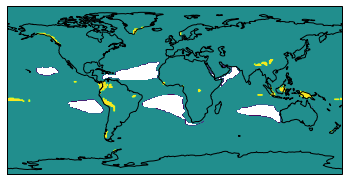

masked_array(
  data=[[86400000., 86400000., 86400000., ..., 86400000., 86400000.,
         86400000.],
        [86400000., 86400000., 86400000., ..., 86400000., 86400000.,
         86400000.],
        [86400000., 86400000., 86400000., ..., 86400000., 86400000.,
         86400000.],
        ...,
        [86400000., 86400000., 86400000., ..., 86400000., 86400000.,
         86400000.],
        [86400000., 86400000., 86400000., ..., 86400000., 86400000.,
         86400000.],
        [86400000., 86400000., 86400000., ..., 86400000., 86400000.,
         86400000.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [31]:
"""
Example cartopy plot

http://earthpy.org/tag/cartopy.html
https://scitools.org.uk/cartopy/docs/v0.16/matplotlib/advanced_plotting.html
"""

import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
from matplotlib import cm
import cartopy.crs as ccrs

from cartopy.util import add_cyclic_point

# #Get example netcdf
# glens_dir = '/n/home03/pjirvine/keithfs1_pji/GLENS/combined_annual_data/'
# glens_filename = 'control.001.cam.h0.TREFHT.ann.201001-209912.nc'
# glens_fileloc = glens_dir + glens_filename
# test_nc = Dataset(glens_fileloc)

# nc_data = test_nc.variables['TREFHT'][:].transpose()
# data = np.mean(nc_data,2)

# data = all_masks['land_noice_mask'].transpose()

data = all_data[('P-E','Baseline')][0]

ax = plt.axes(projection=ccrs.PlateCarree())

# plt.figure(figsize=(13,6.2))  
# ax = plt.subplot(111, projection=ccrs.PlateCarree())

lons2d, lats2d = np.meshgrid(lons, lats)

plt.contourf(lons2d, lats2d, data.transpose(), 60,
             transform=ccrs.PlateCarree())

ax.coastlines()

# fig.colorbar(cm.ScalarMappable(),ax=ax)

plt.show()

data

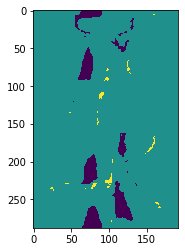

In [26]:
plt.imshow(all_data[('P-E','RCP8.5')][0])